### EXTRACT "FOVEATED" OBJECTS FROM HVM IMAGES

In [8]:
import scipy, random, os, h5py, pickle, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### EXTRACT HVM DATA

In [17]:
ventral_neural_data_path = '../electrophysiological/ventral_neural_data.hdf5'

In [18]:
data = h5py.File(ventral_neural_data_path, 'r')
def make_list(l): return np.array([i.decode() for i in l])
images = np.array(data['images'])
category_names = np.unique(make_list(data['image_meta']['category']))
category_labels = make_list(data['image_meta']['category'])
object_labels = make_list(data['image_meta']['object_name'])
variation_labels = make_list(data['image_meta']['variation_level'])
variation_levels = np.unique(variation_labels)
n_stimuli = len(data['image_meta']['object_name'])
neural_data = np.array(data['time_averaged_trial_averaged'])
y_location = np.array(data['image_meta']['translation_z']) 
x_location = np.array(data['image_meta']['translation_y'])
sizes = np.array(data['image_meta']['size'])
#data.close()

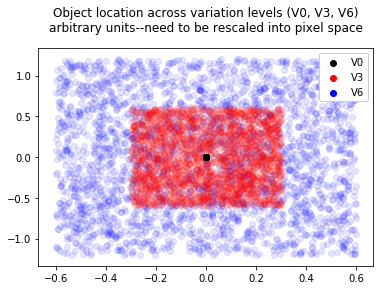

In [10]:
Cs = {'V0':'black', 'V3':'red', 'V6':'blue'}

for i_variation in variation_levels[-1::-1] : 
    x_subset = x_location[variation_labels==i_variation]
    y_subset = y_location[variation_labels==i_variation]
    plt.scatter(x=x_subset, y=y_subset,alpha=.1, color=Cs[i_variation])
    
[plt.scatter([], [], color=Cs[i], label=i) for i in variation_levels]
plt.legend(framealpha=1) 
plt.title('Object location across variation levels (V0, V3, V6)\narbitrary units--need to be rescaled into pixel space', y=1.05); 

### DEFINE FUNCTION TO EXTRACT "FOVEATED" OBJECTS

In [11]:
def crop_image(i, diameter=50, images=images, xl=x_location, yl=y_location, sizes=sizes,categories=category_labels): 
    """
    'foveate' object in each image by creating a smaller bounding box around object:
    - convert metadata into pixel coordinates 
    - deal with inconsistencies
    - adjust bounding box if it exceeds image dimensions
    """
    def check_bounding_box(min_, max_): 
        """ adjust if bounding box exceeds image size"""     
        if min_ < 0: 
            min_, max_ = 0, window_size * 2
        if max_ > image_xy: 
            min_, max_ = image_xy - (window_size * 2), image_xy
        return min_, max_
    
    # to align the y location between metadata adn pixels we need different scaling factors
    scale_y = {'Faces':1,'Planes':.7,'Chairs':.8,'Animals':.7,'Boats':.4,'Cars':.4,'Fruits':.7,'Tables':.7}
    scale_w = {'Faces':.8,'Planes':1,'Chairs':1.2,'Animals':1,'Boats':.9,'Cars':.8,'Fruits':1,'Tables':1}
    
    # get image and its metadata
    IMAGE = images[i]   
    image_xy = images[i].shape[0]
    object_size = sizes[i]
    category = categories[i]
    object_ = object_labels[i]
    X, Y = xl[i], yl[i]
    
    # adjust windown to reflect object size
    window_size = int(diameter * (object_size + .3) * scale_w[category] )
    # align metadata with x axis image pixels
    x_center = int(-(X*int(image_xy/2)) + int(image_xy/2))
    # align metadata with y axis image pixels--scale by category specific factor
    y_center = int(-(Y*int(image_xy/2)*scale_y[category]*1) + int(image_xy/2))
    # set the y min and max of the fovea/bounding box
    min_y, max_y = y_center-window_size, y_center+window_size
    # adjust if bounding box exceeds image size
    min_y, max_y = check_bounding_box(min_y, max_y) 
    # set the x min and max of the fovea/bounding box
    min_x, max_x = x_center-window_size, x_center+window_size
    # adjust if bounding box exceeds image size
    min_x, max_x = check_bounding_box(min_x, max_x) 
    # generate foveated image
    foveated_image = IMAGE[min_y:max_y, min_x:max_x]
    
    return foveated_image, x_center, y_center

### VISUALIZE EXAMPLE STIMULI ACROSS CATEGORIES

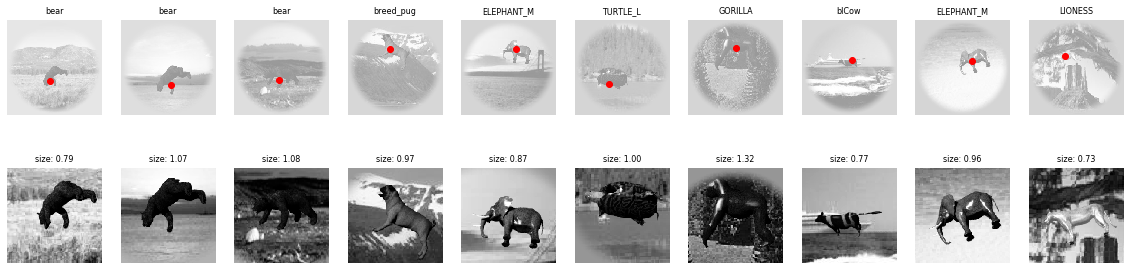

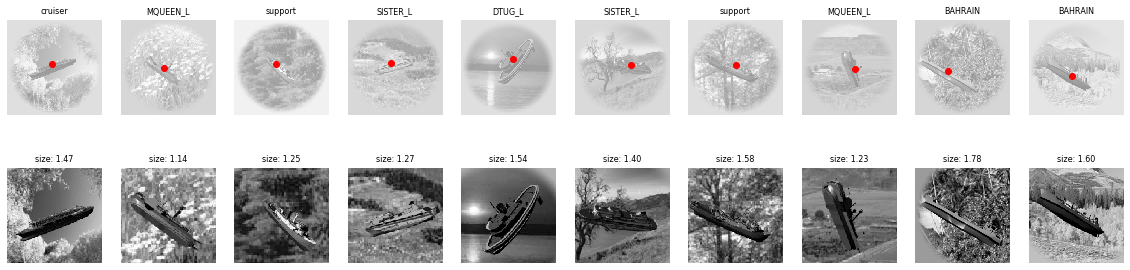

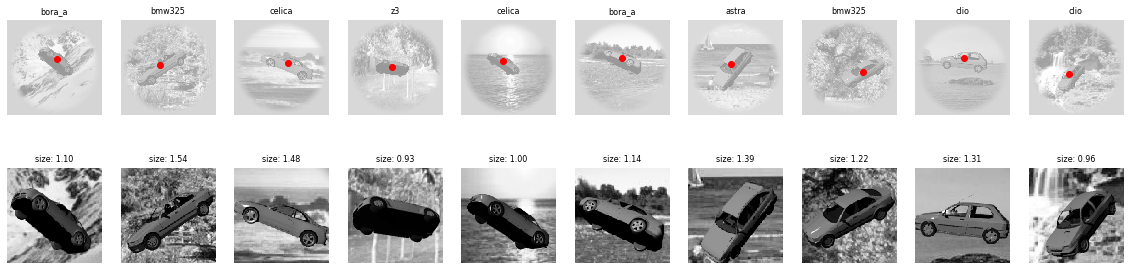

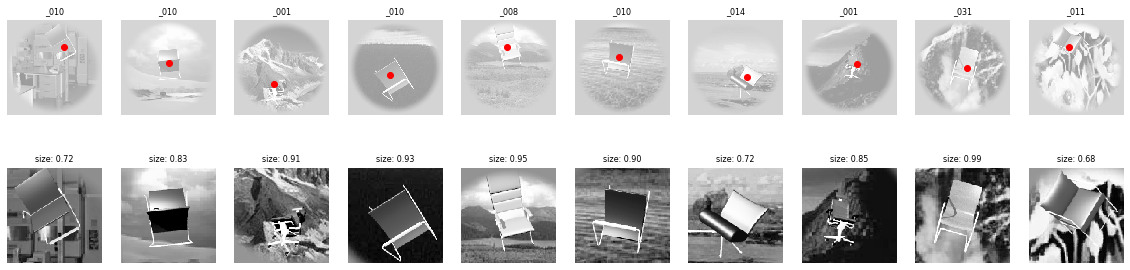

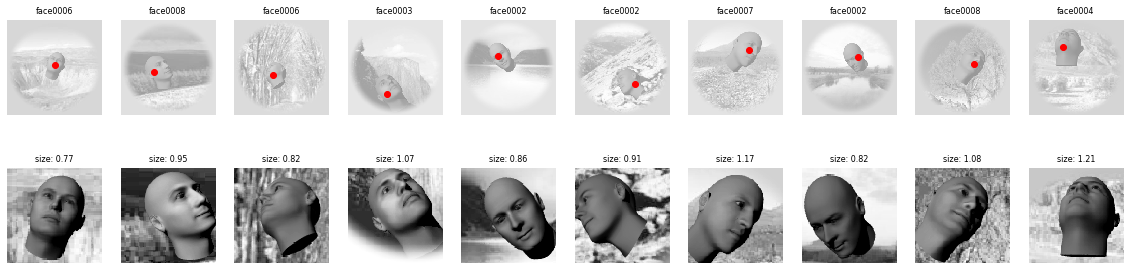

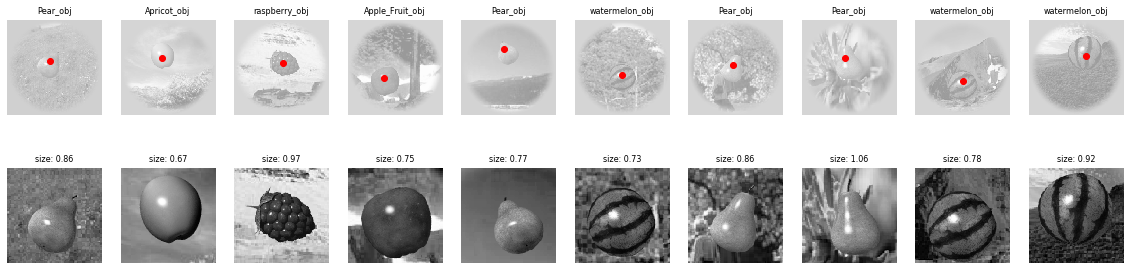

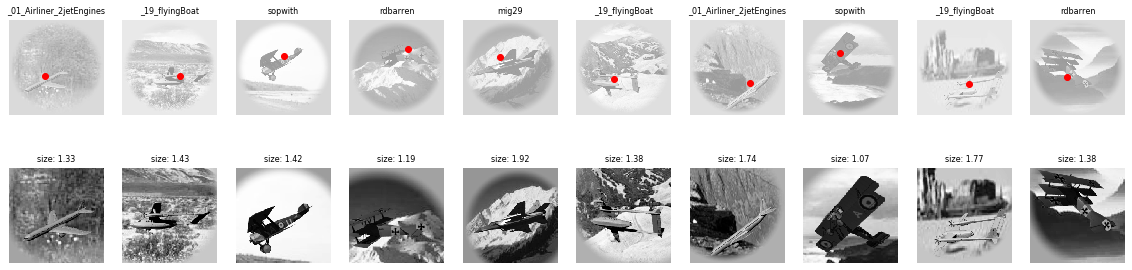

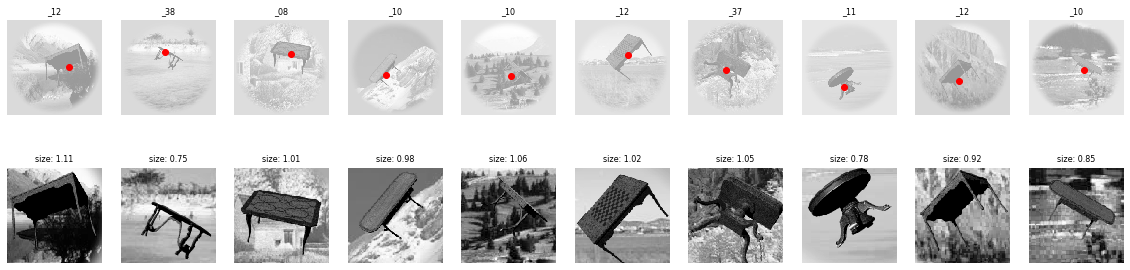

In [12]:
n_images = 10
category_examples = {} 

for i_category in category_names: 
    
    plt.figure(figsize=[20, 5])
    idxs = np.random.permutation(np.nonzero((category_labels == i_category) * (variation_labels=='V3') )[0])
    category_examples[i_category] = idxs[0:n_images]
    
    ii=1
    for i_image in category_examples[i_category]: 
        
        i_cropped_image, x_center, y_center = crop_image(i_image)
        plt.subplot(2, n_images, ii) ; 
        plt.imshow(images[i_image], cmap='Greys_r', alpha=.4) 
        plt.scatter(x_center, y_center, color='red')
        plt.title( object_labels[i_image], fontsize=8)
        plt.axis('off');
        
        plt.subplot(2, n_images, ii+n_images) ; ii+=1
        plt.title('size: %.02f'%sizes[i_image], fontsize=8)
        plt.imshow(i_cropped_image, cmap='Greys_r')
        plt.axis('off');

### EXTRACT ALL STIMULI AND SAVE

In [13]:
# extract 'foveated' images
foveated_objects = np.array([crop_image(i)[0] for i in range(n_stimuli)])
# reshape to 224 x 224 
foveated_objects = [np.array(Image.fromarray(i_image).resize((224, 224))) for i_image in foveated_objects] 
# save for later analysis
np.save('foveated_objects', foveated_objects, allow_pickle=True)

### VALIDATE FUNCTION

In [15]:
import foveate

In [20]:
data = h5py.File(ventral_neural_data_path, 'r')
objects = foveate.all_stimuli(data) 
data.close() 

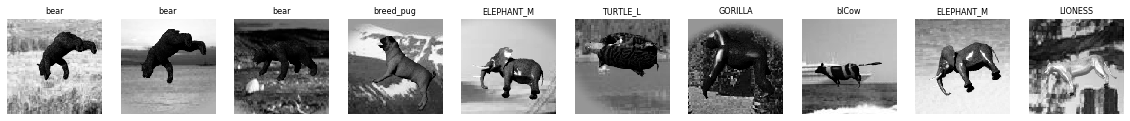

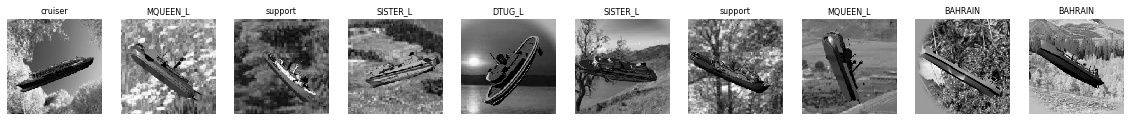

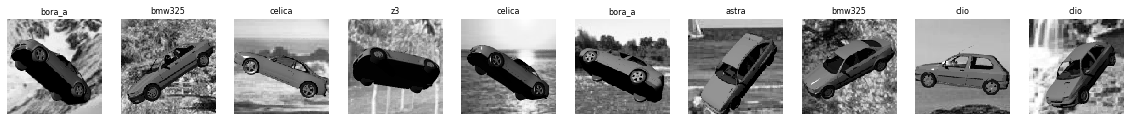

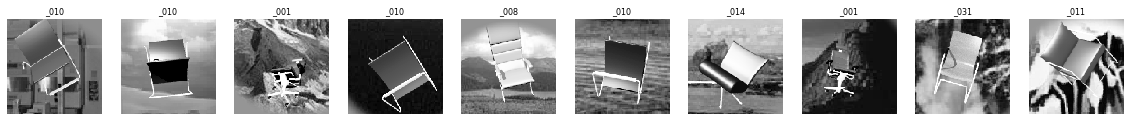

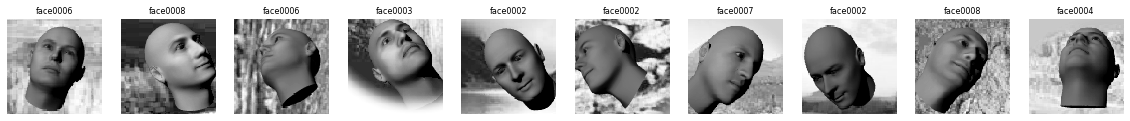

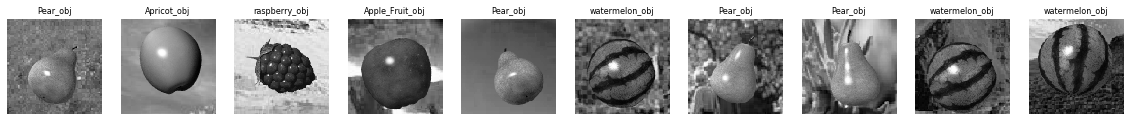

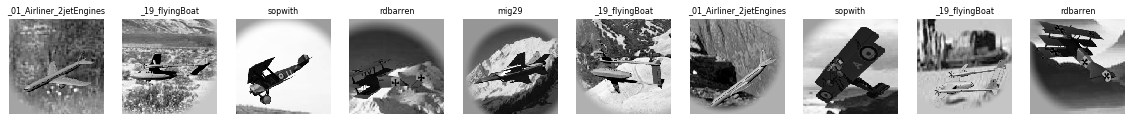

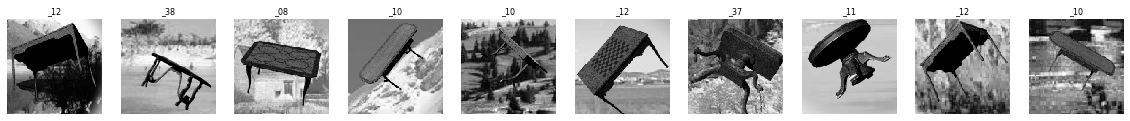

In [21]:
for i_category in category_names: 
    
    plt.figure(figsize=[20, 5])
    
    ii=1
    for i_image in category_examples[i_category]: 
        
        plt.subplot(1, n_images, ii) ; ii+=1
        plt.title( object_labels[i_image], fontsize=8)
        plt.imshow(objects[i_image], cmap='Greys_r')
        plt.axis('off');